In [189]:
import pandas as pd
import numpy as np
import networkx as nx
from tqdm import tqdm
from torch_geometric.data import Data
import random

In [2]:
data = pd.read_csv('data/ALLFLOWMETER_HIKARI2022.csv', index_col=0)

In [9]:
data.head()

,uid,originh,originp,responh,responp,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,...,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,bwd_last_window_size,attack_category,Label
0,Cmu9v81jToQyRF1gbk,184.0.48.168,38164,184.0.48.150,50443,0 days 00:00:00.000060,1,1,0,0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,64240,0,64240,0,Benign,0
1,CO21hl3TWkuXTOgajk,184.0.48.169,43068,184.0.48.150,50443,0 days 00:00:00.000083,1,1,0,0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,64240,0,64240,0,Benign,0
2,CBLJ6L19FP0MfYX7Oh,184.0.48.124,5678,255.255.255.255,5678,0 days 00:01:59.996602,3,0,3,0,...,5.999912e+07,1.199966e+08,5.999830e+07,1156.846698,0,0,0,0,Benign,0
3,ChTG451zJ7hUYOcqje,184.0.48.124,5678,255.255.255.255,5678,0 days 00:00:59.996909,2,0,2,0,...,5.999691e+07,5.999691e+07,5.999691e+07,0.000000,0,0,0,0,Benign,0
4,Cn9y6E2KVxzQbs5wjc,184.0.48.124,5678,255.255.255.255,5678,0 days 00:00:59.992130,2,0,2,0,...,5.999213e+07,5.999213e+07,5.999213e+07,0.000000,0,0,0,0,Benign,0


In [3]:
data.columns

Index(['uid', 'originh', 'originp', 'responh', 'responp', 'flow_duration',
       'fwd_pkts_tot', 'bwd_pkts_tot', 'fwd_data_pkts_tot',
       'bwd_data_pkts_tot', 'fwd_pkts_per_sec', 'bwd_pkts_per_sec',
       'flow_pkts_per_sec', 'down_up_ratio', 'fwd_header_size_tot',
       'fwd_header_size_min', 'fwd_header_size_max', 'bwd_header_size_tot',
       'bwd_header_size_min', 'bwd_header_size_max', 'flow_FIN_flag_count',
       'flow_SYN_flag_count', 'flow_RST_flag_count', 'fwd_PSH_flag_count',
       'bwd_PSH_flag_count', 'flow_ACK_flag_count', 'fwd_URG_flag_count',
       'bwd_URG_flag_count', 'flow_CWR_flag_count', 'flow_ECE_flag_count',
       'fwd_pkts_payload.min', 'fwd_pkts_payload.max', 'fwd_pkts_payload.tot',
       'fwd_pkts_payload.avg', 'fwd_pkts_payload.std', 'bwd_pkts_payload.min',
       'bwd_pkts_payload.max', 'bwd_pkts_payload.tot', 'bwd_pkts_payload.avg',
       'bwd_pkts_payload.std', 'flow_pkts_payload.min',
       'flow_pkts_payload.max', 'flow_pkts_payload.tot',
   

In [3]:
features = ['flow_duration',
       'fwd_pkts_tot', 'bwd_pkts_tot', 'fwd_data_pkts_tot',
       'bwd_data_pkts_tot', 'fwd_pkts_per_sec', 'bwd_pkts_per_sec',
       'flow_pkts_per_sec', 'down_up_ratio', 'fwd_header_size_tot',
       'fwd_header_size_min', 'fwd_header_size_max', 'bwd_header_size_tot',
       'bwd_header_size_min', 'bwd_header_size_max', 'flow_FIN_flag_count',
       'flow_SYN_flag_count', 'flow_RST_flag_count', 'fwd_PSH_flag_count',
       'bwd_PSH_flag_count', 'flow_ACK_flag_count', 'fwd_URG_flag_count',
       'bwd_URG_flag_count', 'flow_CWR_flag_count', 'flow_ECE_flag_count',
       'fwd_pkts_payload.min', 'fwd_pkts_payload.max', 'fwd_pkts_payload.tot',
       'fwd_pkts_payload.avg', 'fwd_pkts_payload.std', 'bwd_pkts_payload.min',
       'bwd_pkts_payload.max', 'bwd_pkts_payload.tot', 'bwd_pkts_payload.avg',
       'bwd_pkts_payload.std', 'flow_pkts_payload.min',
       'flow_pkts_payload.max', 'flow_pkts_payload.tot',
       'flow_pkts_payload.avg', 'flow_pkts_payload.std', 'fwd_iat.min',
       'fwd_iat.max', 'fwd_iat.tot', 'fwd_iat.avg', 'fwd_iat.std',
       'bwd_iat.min', 'bwd_iat.max', 'bwd_iat.tot', 'bwd_iat.avg',
       'bwd_iat.std', 'flow_iat.min', 'flow_iat.max', 'flow_iat.tot',
       'flow_iat.avg', 'flow_iat.std', 'payload_bytes_per_second',
       'fwd_subflow_pkts', 'bwd_subflow_pkts', 'fwd_subflow_bytes',
       'bwd_subflow_bytes', 'fwd_bulk_bytes', 'bwd_bulk_bytes',
       'fwd_bulk_packets', 'bwd_bulk_packets', 'fwd_bulk_rate',
       'bwd_bulk_rate', 'active.min', 'active.max', 'active.tot', 'active.avg',
       'active.std', 'idle.min', 'idle.max', 'idle.tot', 'idle.avg',
       'idle.std', 'fwd_init_window_size', 'bwd_init_window_size',
       'fwd_last_window_size', 'bwd_last_window_size']

In [5]:
len(features)

80

In [4]:
unique_originh = list(set(data['originh']))
unique_responh = list(set(data['responh']))
unique_all = list(set(unique_originh + unique_responh))

In [5]:
node_ip_to_id = {}
for i, ip in enumerate(unique_all):
    node_ip_to_id[ip] = i


In [17]:
# sources = [node_ip_to_id[x] for x in data['originh'].values]
# targets = [node_ip_to_id[x] for x in data['responh'].values]
# G.add_edges_from([(s, t) for s, t in zip(sources, targets)])

In [6]:
G = nx.Graph()

In [7]:
for i, row in tqdm(data.iterrows(), total=len(data)):
    G.add_edge(row['originh'], row['responh'])

100%|████████████████████████████████████████████████████████████████████████| 228253/228253 [00:12<00:00, 17836.51it/s]


In [345]:
sample_node = np.random.choice(unique_originh, 1)[0]

In [346]:
hop = 10
cut_off = 30
nodes = [sample_node]
frontier = [sample_node]
visited = [sample_node]
for h in range(hop):
    new_frontier = []
    for f in frontier:
        neighbours = [x for x in list(G.adj[f]) if x not in visited]
        if len(neighbours) == 0:
            continue
        elif len(neighbours) > cut_off:
            neighbours = random.sample(neighbours, cut_off)
        print(neighbours)

        nodes += neighbours
        new_frontier += neighbours
        visited.append(f)
    frontier = new_frontier


['184.0.48.169']
['182.2.42.19', '36.80.165.48', '182.2.41.132', '36.72.212.225', '125.163.225.203', '140.213.166.64', '182.2.72.145', '180.246.159.96', '182.2.42.244', '114.10.23.104', '114.10.20.246', '202.152.137.41', '140.213.164.41', '36.72.213.118', '182.2.43.56', '125.161.216.234', '140.213.59.188', '114.142.171.9', '140.213.164.27', '36.73.45.51', '36.71.90.9', '182.2.39.17', '114.10.21.211', '182.2.75.130', '36.72.215.131', '182.2.72.132', '182.2.74.170', '114.142.168.8', '36.72.215.239', '36.72.215.130']
['172.18.0.2']
['140.213.176.113', '103.210.35.66', '114.79.46.145', '114.142.168.22', '140.213.162.239', '103.210.35.114', '58.145.168.130', '103.210.35.102', '36.81.70.188', '140.213.170.190', '180.246.159.135', '140.213.44.229', '140.213.177.58', '114.142.171.46', '140.213.160.72', '103.210.35.95', '103.143.100.34', '140.213.162.127', '140.213.166.45', '36.71.88.197', '36.78.54.182', '114.10.7.204', '182.2.38.88', '114.10.4.61', '103.131.104.49', '140.213.166.96', '140.213

In [347]:
[x for x in list(G.adj[f]) if x not in visited]

[]

In [348]:
subgraph = G.subgraph(nodes)

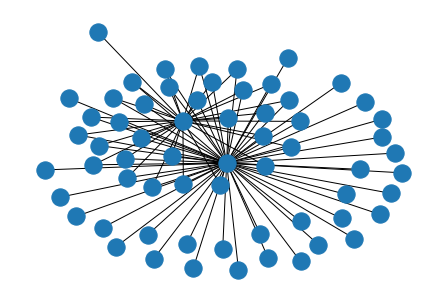

In [349]:
nx.draw(subgraph)

In [353]:
id_graph = nx.convert_node_labels_to_integers(subgraph)

In [360]:
id_graph.edges

EdgeView([(0, 62), (0, 21), (1, 62), (1, 21), (2, 62), (2, 21), (3, 62), (4, 62), (5, 62), (6, 62), (6, 21), (7, 62), (8, 62), (8, 21), (9, 62), (9, 21), (10, 62), (11, 62), (11, 21), (12, 62), (13, 62), (13, 21), (14, 62), (15, 62), (16, 62), (16, 21), (17, 62), (17, 21), (18, 62), (19, 62), (20, 62), (21, 36), (21, 23), (21, 44), (21, 28), (21, 38), (21, 33), (21, 45), (21, 50), (21, 31), (21, 42), (21, 22), (21, 29), (21, 27), (21, 26), (21, 61), (21, 51), (21, 43), (21, 46), (21, 47), (21, 39), (21, 52), (22, 62), (23, 62), (24, 62), (25, 62), (27, 62), (28, 62), (29, 62), (30, 62), (31, 62), (32, 62), (33, 62), (34, 62), (35, 62), (36, 62), (37, 62), (38, 62), (39, 62), (40, 62), (41, 62), (42, 62), (43, 62), (44, 62), (45, 62), (46, 62), (47, 62), (48, 62), (49, 62), (50, 62), (51, 62), (52, 62), (53, 62), (54, 62), (55, 62), (56, 62), (57, 62), (58, 62), (59, 62), (60, 62), (61, 62)])

In [54]:
for s, t in subgraph.edges:
    temp_df = data[(data['originh'] == s) & (data['responh'] ==t)]
    temp_features = temp_df[features]
    if 'flow_duration' in features:
        temp_features['flow_duration'] = temp_features['flow_duration'].apply(lambda x: flow_duration_to_float(x))
    # pandas.DataFrame.sample
    break

In [28]:
np.unique(data['attack_category'])

array(['Benign', 'Bruteforce', 'Bruteforce-XML', 'XMRIGCC CryptoMiner'],
      dtype=object)

In [33]:
data.attack_category.value_counts()

Benign                 214904
XMRIGCC CryptoMiner      7595
Bruteforce-XML           3650
Bruteforce               2104
Name: attack_category, dtype: int64

In [44]:
temp_df[features].iloc[0]['flow_duration']

6.1e-05

In [45]:
def flow_duration_to_float(flow):
    days = float(flow.split('days', 1)[0].strip())
    hh = days * 24
    remain = flow.split('days', 1)[1]
    hh += float(remain.split(':', 1)[0].strip())
    mm = hh * 60
    remain = remain.split(':', 1)[1]
    mm += float(remain.split(':', 1)[0].strip())
    remain = remain.split(':', 1)[1]
    ss = mm * 60
    ss += float(remain)
    return ss

In [56]:
temp_features['flow_duration'] = temp_features['flow_duration'].apply(lambda x: flow_duration_to_float(x))

/tmp/ipykernel_390/182727174.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_features['flow_duration'] = temp_features['flow_duration'].apply(lambda x: flow_duration_to_float(x))


In [449]:
ba_graph = nx.barabasi_albert_graph(20,2)
ba_graph2 = nx.barabasi_albert_graph(20,2)
# nx.draw(ba_graph)
nx.is_isomorphic(ba_graph, ba_graph2)

False

False